In [1]:
import os
os.chdir('../')

In [2]:
import datetime
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
from scipy import stats
from torch.nn.functional import cosine_similarity

from src.DRL.qnetwork import QNetwork
from src.utils import set_size_and_get_figsize
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances
from src.XAI.train_probes import get_hyperparams_combinations

/tmp/ipykernel_24842/3059646118.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#model_path = QNetwork.find_newest_model()
#model_path = 'runs/20240416-095130/model_9999000.pt'
#model_path = "runs/20240317-112025/model_10000000.pt"
model_path = "runs/20240322-100656/model_5000000.pt"

model = QNetwork(model_path=model_path)
layer = 5

env_steps = Concept.load_concept_data()
actions = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']

load = False
max_size = 10000
num_cavs = 50
p_value = 0.05 / len(concept_instances)
print(f'p_value: {p_value}')

hyperparam_ranges = {
    'lr': (0.01, 0.001),
    'batch_size': (64,),
    'lambda_l1': (0.0,),
    'patience': (5,),
    'epochs': (100,)
}
hyperparams = get_hyperparams_combinations(hyperparam_ranges)

Loaded model: 20240322-100656-5000000
p_value: 0.002272727272727273


In [4]:
def get_cav(concept):
    concept.prepare_data(env_steps, max_size=max_size)
    probe, info, best_hyperparams = train_probes(model, concept, hyperparams, [layer])
    score = info[layer]['test_score'][-1]
    #print(f"Score: {score}", end=', ')
    probe = probe[layer]

    CAV = probe[1].weight.data.cpu().numpy().squeeze()
    CAV = torch.tensor(CAV, dtype=torch.float32)
    
    return CAV

In [5]:
def get_gradients(concept, CAV):
    # Get Q-values and test activations
    _, acts_dict = model(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]
    
    # Additional forward pass (return_acts=True detaches from graph)
    acts.requires_grad_(True)
    q_values = model.network[layer + 1:](acts)

    # Tensor to store gradients
    gradients = torch.zeros_like(q_values)
    
    # Compute gradients for each action
    for j in range(q_values.shape[1]):
        model.zero_grad()
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        grads_flat = acts.grad.reshape(acts.shape[0], -1)
        # Dot with CAV (as in TCAV paper equation)
        gradients[:, j] = torch.mv(grads_flat, CAV)
    
        acts.grad.zero_()

    return gradients

In [6]:
def get_TCAV(gradients):
    TCAV = sum(gradients > 0) / gradients.shape[0]
    return TCAV.cpu().numpy()

In [7]:
def get_TCAVs(concept):
    CAVS = [] # Too check similarity between CAVs
    if concept.binary:
        concept_random = concept_instances['Random binary']
    else:
        concept_random = concept_instances['Random continuous']
    actual_TCAVs = []
    random_TCAVs = []
    for i in tqdm.tqdm(range(num_cavs)):
        CAV = get_cav(concept)
        CAVS.append(CAV)
        gradients = get_gradients(concept, CAV)
        actual_TCAVs.append(get_TCAV(gradients))
        
        CAV = get_cav(concept_random)
        gradients = get_gradients(concept, CAV)
        random_TCAVs.append(get_TCAV(gradients))
            
    # Calculate mean similarity between CAVs
    similarity = 0
    num_similarities = 0
    for i in range(num_cavs):
        for j in range(i + 1, num_cavs):
            similarity += cosine_similarity(CAVS[i].unsqueeze(0), CAVS[j].unsqueeze(0))
            num_similarities += 1
    print(f"Mean similarity between CAVs: {similarity / num_similarities}")
    return actual_TCAVs, random_TCAVs

In [8]:
def metric_significant(actual_metrics, random_metrics):
    result = stats.ttest_ind(actual_metrics, random_metrics, equal_var=False)
    return result.pvalue < p_value

In [9]:
def get_metrics(concept):
    actual_TCAVs, random_TCAVs = get_TCAVs(concept)
    #print(f"Actual TCAVs: {actual_TCAVs}")
    #print(f"Random TCAVs: {random_TCAVs}")
    action_means = []
    action_medians = []
    for i in range(len(actions)):
        action_means.append(np.mean([TCAV[i] for TCAV in actual_TCAVs]))
        action_medians.append(np.median([TCAV[i] for TCAV in actual_TCAVs]))
    # Changed from mean to max
    actual_TCAVs = [np.max(TCAV) for TCAV in actual_TCAVs]
    random_TCAVs = [np.max(TCAV) for TCAV in random_TCAVs]
    mean = np.mean(actual_TCAVs) # Use value corresponding to largest Q-value? (not largest gradient)
    low_ci, high_ci = np.percentile(actual_TCAVs, [2.5, 97.5])
    significant = metric_significant(actual_TCAVs, random_TCAVs)
    return mean, low_ci, high_ci, significant, action_means, action_medians

In [10]:
if not load:
    data = []
    for concept in list(concept_instances.values()):
        print(f"Concept: {concept.plot_name}")
        #if "coin" not in concept.plot_name:
        #    continue
        data.append((concept.plot_name,) + get_metrics(concept))
    filename = f"runs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}_TCAV_results.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
else:
    filename = "runs/20240403-033855_TCAV_results.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    # Recreate data with different names
    new_data = []
    for point in data:
        new_name = point[0]
        if new_name == 'bullet close':
            continue
        # First letter to uppercase
        new_name = new_name[0].upper() + new_name[1:]
        new_name = new_name.replace('events', 'event')
        if new_name == 'Bullet aligned with player':
            new_name = 'Player bullet aligned'
        if new_name == 'Good coin left of player':
            new_name = 'Player right good coin'
        new_data.append((new_name,) + point[1:])
    data = new_data

Concept: Random binary


100%|██████████| 50/50 [08:25<00:00, 10.12s/it]


Mean similarity between CAVs: tensor([2.8300e-05])
Concept: Random continuous


100%|██████████| 50/50 [08:28<00:00, 10.17s/it]


Mean similarity between CAVs: tensor([0.0004])
Concept: Player on grass


100%|██████████| 50/50 [24:57<00:00, 29.95s/it]


Mean similarity between CAVs: tensor([0.5166])
Concept: Player on wall


100%|██████████| 50/50 [26:00<00:00, 31.22s/it]


Mean similarity between CAVs: tensor([0.5891])
Concept: Player in air


100%|██████████| 50/50 [24:19<00:00, 29.19s/it]


Mean similarity between CAVs: tensor([0.5147])
Concept: Player dodging


100%|██████████| 50/50 [26:03<00:00, 31.26s/it]


Mean similarity between CAVs: tensor([0.6468])
Concept: Player dodging on wall


100%|██████████| 50/50 [12:58<00:00, 15.57s/it]


Mean similarity between CAVs: tensor([0.6225])
Concept: Player bullet aligned


100%|██████████| 50/50 [18:53<00:00, 22.66s/it]


Mean similarity between CAVs: tensor([0.5026])
Concept: Player right good coin


100%|██████████| 50/50 [24:55<00:00, 29.90s/it]


Mean similarity between CAVs: tensor([0.4893])
Concept: Total wall area


100%|██████████| 50/50 [09:05<00:00, 10.92s/it]


Mean similarity between CAVs: tensor([0.3185])
Concept: Visible air wall


100%|██████████| 50/50 [26:44<00:00, 32.10s/it]


Mean similarity between CAVs: tensor([0.5607])
Concept: Visible wall


100%|██████████| 50/50 [24:46<00:00, 29.73s/it]


Mean similarity between CAVs: tensor([0.6400])
Concept: Visible bullet


100%|██████████| 50/50 [23:40<00:00, 28.41s/it]


Mean similarity between CAVs: tensor([0.5621])
Concept: Visible lava


100%|██████████| 50/50 [23:14<00:00, 27.88s/it]


Mean similarity between CAVs: tensor([0.5702])
Concept: Visible blue coin


100%|██████████| 50/50 [25:39<00:00, 30.78s/it]


Mean similarity between CAVs: tensor([0.6076])
Concept: Visible gold coin


100%|██████████| 50/50 [20:48<00:00, 24.96s/it]


Mean similarity between CAVs: tensor([0.7604])
Concept: Visible red coin


100%|██████████| 50/50 [13:04<00:00, 15.70s/it]


Mean similarity between CAVs: tensor([0.5618])
Concept: Visible high coin


100%|██████████| 50/50 [30:06<00:00, 36.13s/it]


Mean similarity between CAVs: tensor([0.5795])
Concept: Visible good low coin


100%|██████████| 50/50 [26:03<00:00, 31.28s/it]


Mean similarity between CAVs: tensor([0.6392])
Concept: Event quantity


100%|██████████| 50/50 [09:31<00:00, 11.44s/it]


Mean similarity between CAVs: tensor([0.3408])
Concept: Good event quantity


100%|██████████| 50/50 [09:28<00:00, 11.37s/it]


Mean similarity between CAVs: tensor([0.4259])
Concept: Bad event quantity


100%|██████████| 50/50 [09:09<00:00, 10.99s/it]

Mean similarity between CAVs: tensor([0.3244])


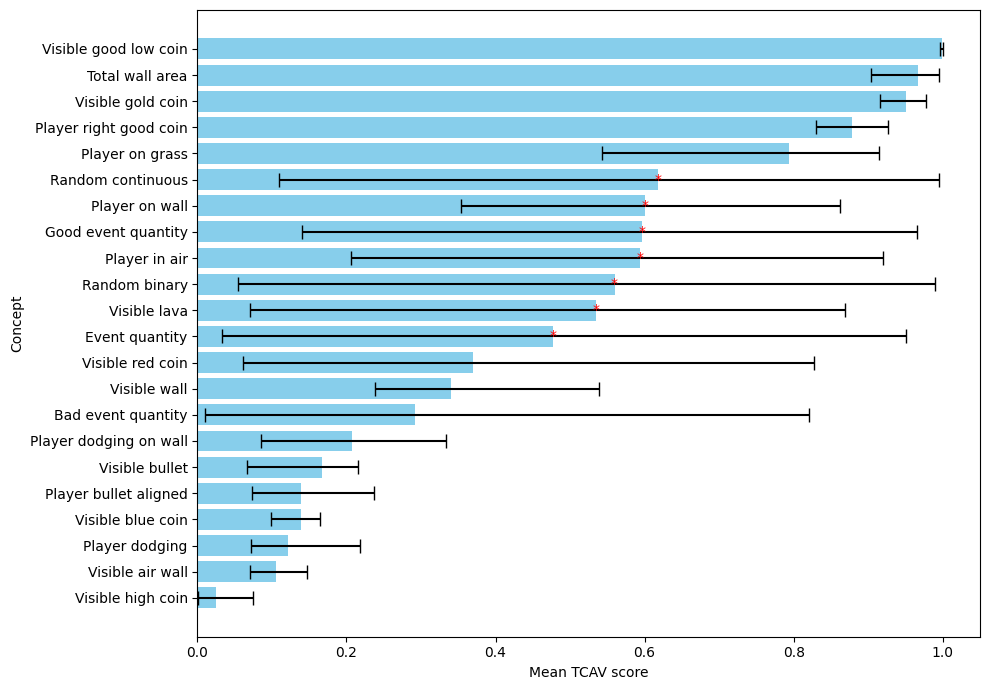

In [11]:
data_sorted = sorted(data, key=lambda x: x[1], reverse=True)

# Splitting the data
concepts = [item[0] for item in data_sorted]
means = [item[1] for item in data_sorted]
low_cis = [item[2] for item in data_sorted]
high_cis = [item[3] for item in data_sorted]
significance = [item[4] for item in data_sorted]
action_means = [item[5] for item in data_sorted]

fig, ax = plt.subplots(figsize=(10,7))
y_pos = np.arange(len(concepts))

errors = [(max(means[i] - low_cis[i], 0), max(high_cis[i] - means[i],0)) for i in range(len(means))]

bars = ax.barh(y_pos, means, xerr=np.array(errors).T, align='center', color='skyblue', ecolor='black', capsize=5)

# Adding a star for non-significant concepts
for bar, sig in zip(bars, significance):
    if not sig:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, '*', ha='center', va='center', color='red')

# Setting labels and title
ax.set_yticks(y_pos)
ax.set_yticklabels(concepts)
ax.set_ylabel('Concept')
ax.set_xlabel('Mean TCAV score')
# ax.set_title('TCAV scores')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

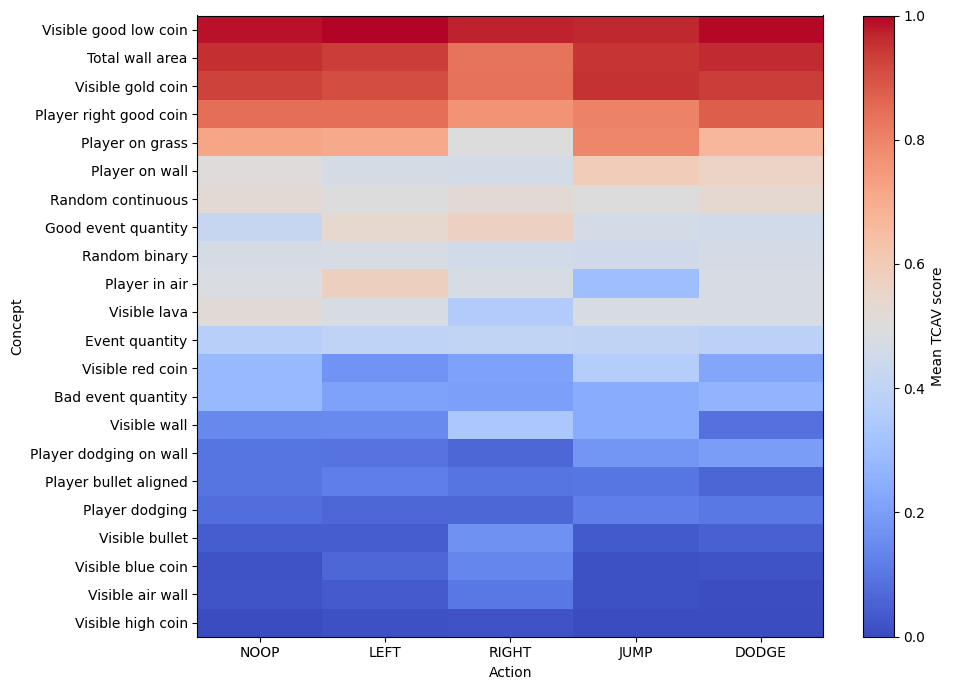

In [12]:
# Seems like mean is not the best metric as RIGHT, which is usually most favorable, but it has some cases where its very bad.
# Thus mean, seems to favor the safer actions that just waits.
matrix = np.array(action_means)

# Calculate the maximum mean gradient value for each concept and get sorted indices
sorted_indices = np.argsort(-matrix.mean(axis=1))
sorted_matrix = matrix[sorted_indices]
sorted_concept_names = np.array(concepts)[sorted_indices]

# Plotting the sorted matrix
plt.figure(figsize=(10, 7))
plt.imshow(sorted_matrix, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Mean TCAV score')
plt.xticks(np.arange(len(actions)), actions, rotation=0)
plt.yticks(np.arange(len(sorted_concept_names)), sorted_concept_names)
#plt.title('TCAV matrix')
plt.xlabel('Action')
plt.ylabel('Concept')
plt.tight_layout()
plt.savefig('figures/conceptual sensitivity/concept-action-mean.png')
plt.show()

In [13]:
model_path = "runs/20240322-100656/model_5000000.pt"
model = QNetwork(model_path=model_path)

Loaded model: 20240322-100656-5000000


In [14]:
concept_instances

{'Random binary': <src.XAI.concept.Concept at 0x7f3743210b50>,
 'Random continuous': <src.XAI.concept.Concept at 0x7f3743210b80>,
 'Player on grass': <src.XAI.concept.Concept at 0x7f3743210c70>,
 'Player on wall': <src.XAI.concept.Concept at 0x7f3743210cd0>,
 'Player in air': <src.XAI.concept.Concept at 0x7f3743210d30>,
 'Player dodging': <src.XAI.concept.Concept at 0x7f3743210d90>,
 'Player dodging on wall': <src.XAI.concept.Concept at 0x7f3743210df0>,
 'Bullet aligned with player': <src.XAI.concept.Concept at 0x7f3743210e50>,
 'Good coin left of player': <src.XAI.concept.Concept at 0x7f3743210eb0>,
 'Total wall area': <src.XAI.concept.Concept at 0x7f3743210f10>,
 'Visible air wall': <src.XAI.concept.Concept at 0x7f37432140d0>,
 'Visible wall': <src.XAI.concept.Concept at 0x7f3743214130>,
 'Visible bullet': <src.XAI.concept.Concept at 0x7f3743214190>,
 'Visible lava': <src.XAI.concept.Concept at 0x7f37432141f0>,
 'Visible blue coin': <src.XAI.concept.Concept at 0x7f3743214250>,
 'Visi

[0.0295 0.0775 0.165  0.0125 0.017 ]


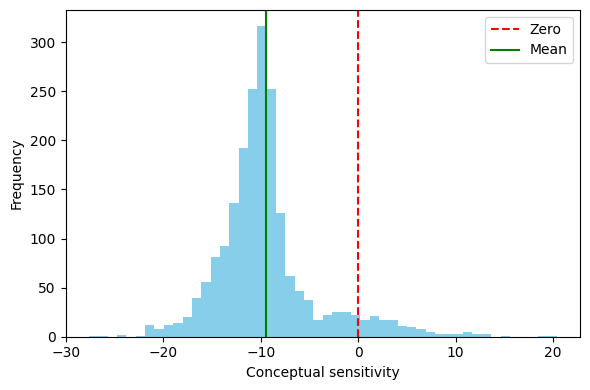

In [15]:
concept = concept_instances['Visible blue coin']

gradients = get_gradients(concept, get_cav(concept))
print(get_TCAV(gradients))
gradients = gradients.mean(dim=1).detach().cpu().numpy()
mean_value = np.mean(gradients)
plt.figure(figsize=(6, 4))
plt.hist(gradients, bins=50, color='skyblue')
plt.xlabel('Conceptual sensitivity')
plt.ylabel('Frequency')
# plt.title(f'Gradient Distribution for "{concept.name}"')

plt.axvline(x=0, color='r', linestyle='--', label='Zero')
plt.axvline(x=mean_value, color='green', linestyle='-', label='Mean')
plt.tight_layout()
plt.legend()
plt.show()

In [17]:
# cool_concepts = [concept_instances['bullet close'], concept_instances['good coin left of player'], concept_instances['player in air']]
# cool_concepts = [concept_instances['player dodging'], concept_instances['visible lava'], concept_instances['visible wall']]
cool_concepts = [concept_instances['Player dodging'], concept_instances['Player in air'], concept_instances['Visible lava'], concept_instances['Bullet aligned with player']]

In [18]:
best_count = {action : [0] * len(cool_concepts) for action in actions}

for c, concept in enumerate(cool_concepts):
    for _ in range(10):
        CAV = get_cav(concept)
        gradients = get_gradients(concept, CAV)
        for i in range(gradients.shape[0]):
            best_action = actions[np.argmax(gradients[i])]
            best_count[best_action][c] += 1

In [19]:
# normalize best_count by dividing by the number of samples column-wise
for i in range(len(cool_concepts)):
    total = sum([best_count[action][i] for action in actions])
    for action in actions:
        best_count[action][i] /= total
best_count

{'NOOP': [0.02665, 0.0348, 0.2551, 0.0406],
 'LEFT': [0.0608, 0.45255, 0.282, 0.5428],
 'RIGHT': [0.46365, 0.3428, 0.07995, 0.2003],
 'JUMP': [0.2581, 0.01595, 0.2269, 0.09725],
 'DODGE': [0.1908, 0.1539, 0.15605, 0.11905]}

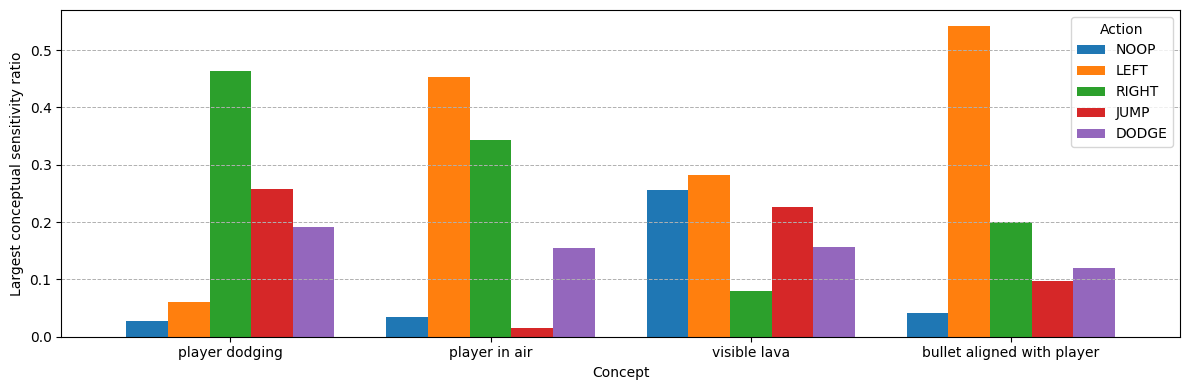

In [20]:
df = pd.DataFrame(best_count, index=[c.name for c in cool_concepts])

# Plotting a bar chart
df.plot(kind='bar', figsize=(12, 4), width=0.8)
# plt.title('Best Actions for Each Concept')
plt.xlabel('Concept')
plt.ylabel('Largest conceptual sensitivity ratio')
plt.xticks(rotation=0)
plt.legend(title='Action')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()

plt.show()